<a href="https://colab.research.google.com/github/Ahmadsaidnouh/Term7-Artificial-Intelligence-Assignments/blob/lab4%2Fhossam/lab4/jupyter%20notebooks/Finallllllll_NLP_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
%pip install transformers
%pip install pandas 
%pip install torch
%pip install tqdm
%pip install nltk
%pip install configparser

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
import gc
import configparser
import ast
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# For first run

In [ ]:
#tztz12344
# from google.colab import drive
# drive.mount('/content/drive')

# For mounting another drive

In [4]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [5]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 129504 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [14]:
df_train = pd.read_csv(f"/content/drive/MyDrive/Lab4_Data/train.csv")
df_val = pd.read_csv(f"/content/drive/MyDrive/Lab4_Data/val.csv")
df_test = pd.read_csv(f"/content/drive/MyDrive/Lab4_Data/test.csv")
# df_train = df_train[0:5000]
# df_val = df_val[0:715]
# df_test = df_test[0:1430]


print(len(df_train), len(df_val), len(df_test))
df_train


35000 5000 10000


,review,sentiment
0,I saw this film in the theater when it first c...,negative
1,"Caught this on IFC yesterday, and can't believ...",negative
2,As a person who knows the filmed ship and some...,negative
3,"As a massive fan of fantasy in general, and of...",positive
4,Antitrust falls right into that category of fi...,negative
...,...,...
34995,"James J. Corbett's autobiography ""The Roar of ...",positive
34996,Everything a musical comedy should be. Gene Ke...,positive
34997,This film is dreadful. It has absolutely zero ...,negative
34998,"This movie had an interesting cast, it mat not...",positive


In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
labels = {
    "negative" : 0 ,
    "positive" : 1,
}


class Dataset(torch.utils.data.TensorDataset):
    def __init__(self, df):

        self.labels = [labels[label] for label in df["sentiment"]]
        # self.labels = []
        # for label in df["sentiment"]:
        #     self.labels.append(label)
        self.texts = [
            tokenizer(
                text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            )
            for text in df["review"]
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [11]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout_bert = nn.Dropout(0.5)
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(768, 512)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 256)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 64)
        self.linear_out = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):
        _, x = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        x = self.dropout_bert(x)
        x = self.relu1(self.linear1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu2(self.linear2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu3(self.linear3(x))
        x = self.dropout(x)
        x = self.relu4(self.linear4(x))
        x = self.dropout(x)
        x = self.sigmoid(self.linear_out(x))
        return x


In [16]:
def save_checkpoint(model, epoch, optimizer, best_acc, model_path):
  state = {
      'epoch' : epoch + 1,
      'model' : model.state_dict(),
      'best accuracy' : best_acc,
      'optimizer' : optimizer.state_dict()
  }
  torch.save(state, model_path)

In [17]:
batch_size=16   
trainn, val, test = Dataset(df_train), Dataset(df_val), Dataset(df_test)

In [10]:
trainn

In [18]:
train_dataloader = torch.utils.data.DataLoader(trainn, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

In [6]:
epoch_list = list()
train_loss = list()
val_loss = list()
train_accuracy = list()
val_accuracy = list()

config_file = '/content/drive/MyDrive/Lab4_Data/config_1e6.ini'

try:
    # Load variables from config file
    config = configparser.ConfigParser()
    config.read(config_file)

    epoch_list = ast.literal_eval(config['VARIABLES']['epoch_list'])
    train_loss = ast.literal_eval(config['VARIABLES']['train_loss'])
    val_loss = ast.literal_eval(config['VARIABLES']['val_loss'])
    train_accuracy = ast.literal_eval(config['VARIABLES']['train_accuracy'])
    val_accuracy = ast.literal_eval(config['VARIABLES']['val_accuracy'])

    print(epoch_list)
    print(train_loss)
    print(val_loss)
    print(train_accuracy)
    print(val_accuracy)

except:
    print(f"Error while reading config file {config_file}")
    # Save variables to config file
    config = configparser.ConfigParser()
    config['VARIABLES'] = {'epoch_list': '[]',
                          'train_loss': '[]',
                          'val_loss': '[]',
                           'train_accuracy': '[]',
                           'val_accuracy': '[]'}

    with open(config_file, 'w') as configfile:
        config.write(configfile)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0.04316789572920118, 0.036369629842894415, 0.026879885980912618, 0.019852178693243436, 0.015580004875149045, 0.013005620658078363, 0.01130908868408629, 0.01008008754679135, 0.00909031551794282, 0.008196531088703446, 0.007525863259844482, 0.006915377276603665]
[0.041994398748874666, 0.03060257521867752, 0.022135640120506287, 0.016902316465973854, 0.014449850930273532, 0.013456169065833091, 0.01327718799188733, 0.013438818528875709, 0.013628842640295624, 0.014107439126074314, 0.014453222445771099, 0.014657443041913212]
[0.5245428571428571, 0.8021714285714285, 0.9042857142857142, 0.9219714285714286, 0.9310857142857143, 0.9398285714285715, 0.9477428571428571, 0.9546571428571429, 0.9592, 0.9637714285714286, 0.9683714285714285, 0.9717428571428571]
[0.5876, 0.8996, 0.9156, 0.92, 0.9234, 0.9268, 0.9272, 0.9264, 0.9274, 0.9266, 0.9264, 0.929]


In [7]:
def plot_all():
    plt.figure(figsize = [18, 5])
    plt.suptitle("Loss and Accuracy in training")
    plt.subplot(1,2,1)
    plt.plot(epoch_list,train_loss);
    plt.plot(epoch_list,val_loss);
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","Validation"])
    plt.subplot(1,2,2)
    plt.plot(epoch_list,train_accuracy);
    plt.plot(epoch_list,val_accuracy);
    plt.xlabel("Epochs");
    plt.ylabel("Accuracy")
    plt.legend(["Train","Validation"]);
    plt.show()
    

In [14]:
def train(model,train_data, val_data, train_dataloader, val_dataloader, learning_rate, epochs, bach_size, best_model_path, last_model_path,start_from_epoch = 0):                    
    # Early stopping
    val_avg_acc_best = 0.92624
    try:
      val_acc_best = max(val_accuracy)
    except:
      val_acc_best = -1000
      print("empty")

    print("Val_best_acc = ", val_acc_best)
    early_stop_items_num = 5

    
    device = torch.device("cuda")

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    model = model.cuda()
    criterion = criterion.cuda()

    try:
      print("Check saved model")
      loaded_checkpoint = torch.load(last_model_path)
      model.load_state_dict(loaded_checkpoint["model"])
      optimizer.load_state_dict(loaded_checkpoint["optimizer"])
      print("Loaded saved model")
    except:
      print("No saved models")

    for epoch_num in range(start_from_epoch,epochs):
            gc.collect()

            model.train()
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                gc.collect()
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)

                batch_loss = criterion(output.squeeze(1), train_label.float())
                total_loss_train += batch_loss.item()

                y_pred_tag = torch.round(output.squeeze(1))
                acc = (y_pred_tag == train_label).sum()

                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            model.eval()
            with torch.no_grad():

                for val_input, val_label in val_dataloader:
                    gc.collect()
                    # torch.cuda.empty_cache()

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output.squeeze(1), val_label.float())
                    total_loss_val += batch_loss.item()
                    
                    y_pred_tag = torch.round(output.squeeze(1))
                    acc = (y_pred_tag == val_label).sum()
                    total_acc_val += acc
            
            train_loss.append(total_loss_train / len(train_data))
            train_accuracy.append(total_acc_train.item() / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            val_accuracy.append(total_acc_val.item() / len(val_data))
            epoch_list.append(epoch_num+1)
            val_acc_new = total_acc_val / len(val_data)
            
            
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
            
            if val_acc_new > val_acc_best:
              val_acc_best = val_acc_new
              save_checkpoint(model, epoch_num, optimizer, val_acc_best, best_model_path)

            save_checkpoint(model, epoch_num, optimizer, val_acc_new, last_model_path)
            
            current_avg_acc = sum(val_accuracy[-early_stop_items_num:])/early_stop_items_num
            val_avg_acc_best = max(val_avg_acc_best, current_avg_acc)
            if epoch_num == start_from_epoch:
              old_avg_acc = current_avg_acc
              
            print("Val_accuracy = ", val_accuracy)
            print("Val_accuracy = ", val_accuracy[-early_stop_items_num:])
            print("current_avg_acc = ", current_avg_acc)
            print("val_avg_acc_best = ", val_avg_acc_best)
            print("Difference = ", (val_avg_acc_best - current_avg_acc))
            print("*************************************************************************************************************\n")

            
            the_current_loss = total_loss_val / len(val_data)
            the_last_loss = the_current_loss
            config.update({'VARIABLES':{
                            'train_loss':train_loss,
                            'val_loss':val_loss,
                            'train_accuracy':train_accuracy,
                            'val_accuracy':val_accuracy,
                            'epoch_list':epoch_list}})
            with open(config_file, 'w') as configfile:
                config.write(configfile)

            # Early stopping
            if len(val_accuracy) >= early_stop_items_num and (((val_avg_acc_best - current_avg_acc) >= 0.04) or ((epoch_num - start_from_epoch) >=2 and abs(old_avg_acc - current_avg_acc) <= 0.02)):
                print("Early stopping at epoch:", epoch_num+1)
                break      

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start epoch =  9
Val_best_acc =  0.9274
Check saved model
Loaded saved model


100%|██████████| 2188/2188 [1:02:05<00:00,  1.70s/it]


Epochs: 10 | Train Loss:  0.008                 | Train Accuracy:  0.964                 | Val Loss:  0.014                 | Val Accuracy:  0.927
Val_accuracy =  [0.5876, 0.8996, 0.9156, 0.92, 0.9234, 0.9268, 0.9272, 0.9264, 0.9274, 0.9266]
Val_accuracy =  [0.9268, 0.9272, 0.9264, 0.9274, 0.9266]
current_avg_acc =  0.92688
val_avg_acc_best =  0.92688
Difference =  0.0
*************************************************************************************************************



100%|██████████| 2188/2188 [1:01:54<00:00,  1.70s/it]


Epochs: 11 | Train Loss:  0.008                 | Train Accuracy:  0.968                 | Val Loss:  0.014                 | Val Accuracy:  0.926
Val_accuracy =  [0.5876, 0.8996, 0.9156, 0.92, 0.9234, 0.9268, 0.9272, 0.9264, 0.9274, 0.9266, 0.9264]
Val_accuracy =  [0.9272, 0.9264, 0.9274, 0.9266, 0.9264]
current_avg_acc =  0.9268000000000001
val_avg_acc_best =  0.92688
Difference =  7.999999999996898e-05
*************************************************************************************************************



100%|██████████| 2188/2188 [1:01:59<00:00,  1.70s/it]


Epochs: 12 | Train Loss:  0.007                 | Train Accuracy:  0.972                 | Val Loss:  0.015                 | Val Accuracy:  0.929
Val_accuracy =  [0.5876, 0.8996, 0.9156, 0.92, 0.9234, 0.9268, 0.9272, 0.9264, 0.9274, 0.9266, 0.9264, 0.929]
Val_accuracy =  [0.9264, 0.9274, 0.9266, 0.9264, 0.929]
current_avg_acc =  0.9271600000000001
val_avg_acc_best =  0.9271600000000001
Difference =  0.0
*************************************************************************************************************

Early stopping at epoch: 12


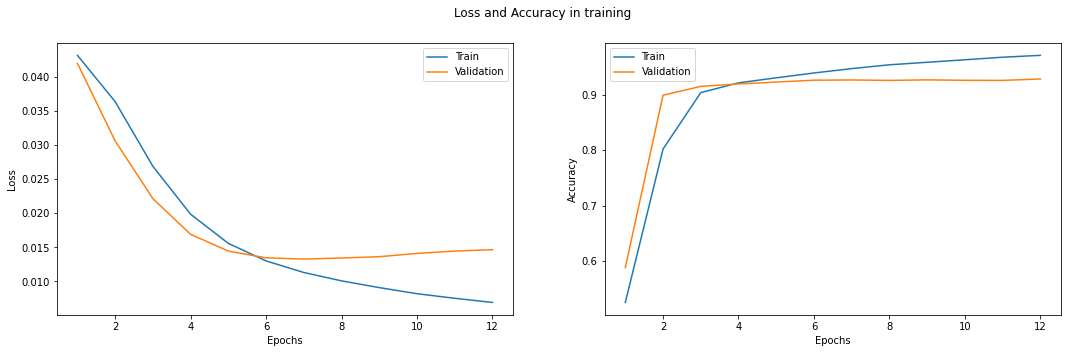

In [15]:
EPOCHS = 10000
LR = 1e-6

model = BertClassifier()



best_model_path = f"/content/drive/MyDrive/Lab4_Data/model_best.pth.tar"
last_model_path = f"/content/drive/MyDrive/Lab4_Data/model_last.pth.tar"
gc.collect()
  
epoch_num = 0

if len(epoch_list) != 0:
  epoch_num = epoch_list[-1]
print("Start epoch = ",epoch_num)
train(model,df_train, df_val, train_dataloader, val_dataloader, LR, EPOCHS,batch_size, best_model_path, last_model_path,start_from_epoch = epoch_num)
plot_all()

In [8]:
print(train_loss)
print(train_accuracy)
print(val_loss)
print(val_accuracy)

print(epoch_list)

[0.04316789572920118, 0.036369629842894415, 0.026879885980912618, 0.019852178693243436, 0.015580004875149045, 0.013005620658078363, 0.01130908868408629, 0.01008008754679135, 0.00909031551794282, 0.008196531088703446, 0.007525863259844482, 0.006915377276603665]
[0.5245428571428571, 0.8021714285714285, 0.9042857142857142, 0.9219714285714286, 0.9310857142857143, 0.9398285714285715, 0.9477428571428571, 0.9546571428571429, 0.9592, 0.9637714285714286, 0.9683714285714285, 0.9717428571428571]
[0.041994398748874666, 0.03060257521867752, 0.022135640120506287, 0.016902316465973854, 0.014449850930273532, 0.013456169065833091, 0.01327718799188733, 0.013438818528875709, 0.013628842640295624, 0.014107439126074314, 0.014453222445771099, 0.014657443041913212]
[0.5876, 0.8996, 0.9156, 0.92, 0.9234, 0.9268, 0.9272, 0.9264, 0.9274, 0.9266, 0.9264, 0.929]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [9]:
from sklearn.metrics import confusion_matrix

def evaluate(model, test_data, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    final_confusion_matrix = np.zeros([2,2])

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    model.eval()
    with torch.no_grad():

        for test_input, test_label in tqdm(test_dataloader):
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              y_pred_tag = torch.round(output.squeeze(1))
              # print(y_pred_tag)
              acc = (y_pred_tag == test_label).sum()
              total_acc_test += acc
              final_confusion_matrix += confusion_matrix(test_label.cpu().data.numpy(), y_pred_tag.cpu().data.numpy())
    
    TP = final_confusion_matrix[0][0]
    FP = final_confusion_matrix[0][1]
    FN = final_confusion_matrix[1][0]
    TN = final_confusion_matrix[1][1]
    Percision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    print(f'\nTest Accuracy: {total_acc_test / len(test_data): .3f}')
    print(f'Percision : {Percision}')
    print(f'Sensitivity (Recall) : {Recall}')
    print(f'Specifity : {TN/(TN+FP)}')
    print(f'F1 Score = {((2*Percision*Recall)/(Percision+Recall))}')
    print('Confusion Matrix :')
    print(final_confusion_matrix)
    
    return final_confusion_matrix
    
    


In [12]:
best_model_path = f"/content/drive/MyDrive/Lab4_Data/model_best.pth.tar"
loaded_checkpoint = torch.load(best_model_path)
model = BertClassifier()
model.load_state_dict(loaded_checkpoint["model"])
print("Epoch num of best model = ",loaded_checkpoint["epoch"])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch num of best model =  12


In [19]:
final_confusion_matrix = evaluate(model, df_test, test_dataloader)

100%|██████████| 625/625 [05:19<00:00,  1.96it/s]


Test Accuracy:  0.931
Percision : 0.9178
Sensitivity (Recall) : 0.9434621710526315
Specifity : 0.9199766355140186
F1 Score = 0.9304541768045417
Confusion Matrix :
[[4589.  411.]
 [ 275. 4725.]]


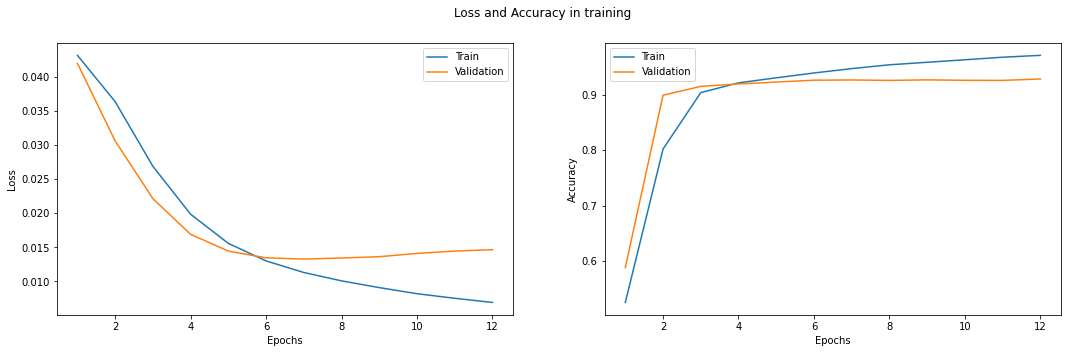

In [20]:
plot_all()